<a href="https://colab.research.google.com/github/katterine2558/mri-tumor-detection-cnn/blob/main/mri_tumor_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#==========================================================
# LIBRARIES
#==========================================================
from google.colab import files
#!pip install -q kaggle #Descomentar si no está instalado Kaggle en el entorno
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import Counter
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Resizing, Rescaling, RandomBrightness, RandomContrast, RandomRotation, RandomZoom, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import AUC
from kerastuner.tuners import RandomSearch


#Ruta base
base_dir = '/content/mri_data'
#Ruta para almacenar split
split_dir = "/content/mri_data_split"
#Semilla
seed = 0;
#Tamaño del batch
batch_size = 32
#Image size
image_size = (224, 224)

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 56% 133M/236M [00:00<00:00, 1.39GB/s]
100% 236M/236M [00:00<00:00, 650MB/s] 
Categorías encontradas: ['healthy', 'meningioma', 'pituitary', 'glioma']
healthy: 2000 imágenes
meningioma: 1645 imágenes
pituitary: 1757 imágenes
glioma: 1621 imágenes


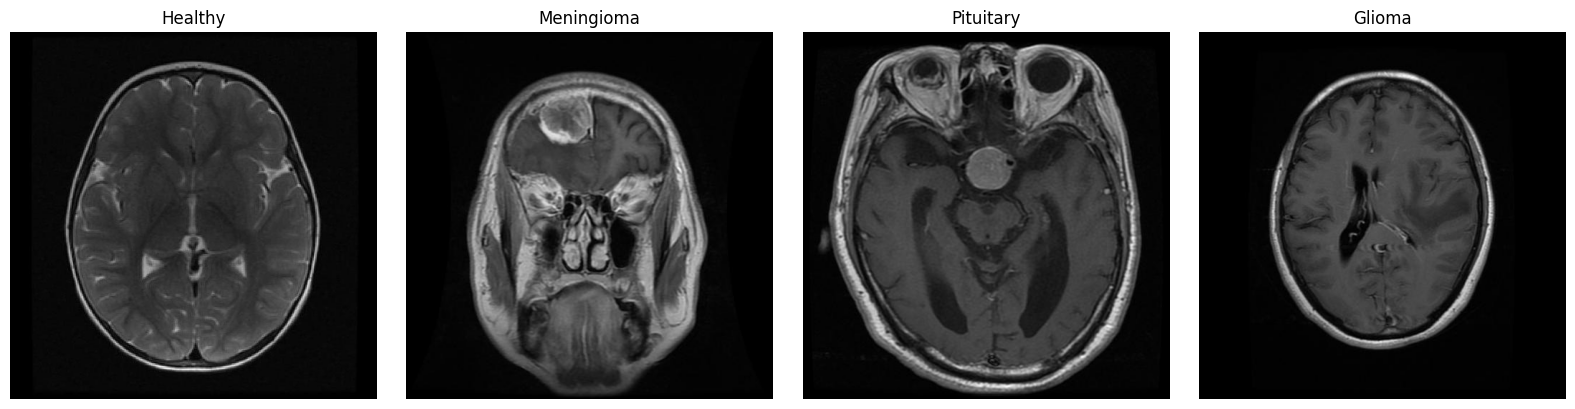

In [4]:
#==========================================================
# DOWNLOAD DATASET
#==========================================================
def download_mri_data(base_dir:str):

  files.upload() #APIKey de Kaggle

  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Descargar el dataset
  !mkdir -p /content/mri_data
  !kaggle datasets download -d rm1000/brain-tumor-mri-scans -p /content/mri_data --unzip

  # Listar categorías
  categories = os.listdir(base_dir)
  print("Categorías encontradas:", categories)

  # Contar imágenes por clase
  for c in categories:
      path = os.path.join(base_dir, c)
      print(f"{c}: {len(os.listdir(path))} imágenes")

  fig, axes = plt.subplots(1, 4, figsize=(16, 4))
  for i, c in enumerate(categories):
      folder = os.path.join(base_dir, c)
      img_name = random.choice(os.listdir(folder))
      img_path = os.path.join(folder, img_name)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[i].imshow(img)
      axes[i].set_title(c.capitalize())
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

#Descarga el conjunto de datos
download_mri_data(base_dir)

In [5]:
#==========================================================
# IMAGE SIZE SCANNER
#==========================================================

def get_images_size(base_dir:str):

  all_sizes = []  # guardamos (ancho, alto)
  per_class_count = {}

  for cls in os.listdir(base_dir):
      cls_path = os.path.join(base_dir, cls)
      if not os.path.isdir(cls_path):
          continue

      imgs = os.listdir(cls_path)
      per_class_count[cls] = len(imgs)

      # vamos a mirar hasta 20 imágenes por clase (para no leer miles)
      for img_name in imgs[:20]:
          img_path = os.path.join(cls_path, img_name)
          img = cv2.imread(img_path)  # esto lee en BGR
          if img is None:
              # a veces hay archivos raros tipo .txt o corruptos
              continue
          h, w, ch = img.shape  # alto, ancho, canales
          all_sizes.append((w, h, ch))


  print("\nEjemplos de tamaños (ancho x alto x canales) en las primeras imágenes revisadas:")
  for s in all_sizes[:10]:
      print(" ", s)

  # estadísticas más globales
  widths = [s[0] for s in all_sizes]
  heights = [s[1] for s in all_sizes]
  channels = [s[2] for s in all_sizes]

  print("\nEstadísticas:")
  print(f"  Ancho min / max / promedio: {min(widths)} / {max(widths)} / {np.mean(widths):.1f}")
  print(f"  Alto  min / max / promedio: {min(heights)} / {max(heights)} / {np.mean(heights):.1f}")

  print("\nCanales más comunes (1=gris, 3=RGB):")
  print(Counter(channels))

#Obtiene el tamaño de las imágenes
get_images_size(base_dir)


Ejemplos de tamaños (ancho x alto x canales) en las primeras imágenes revisadas:
  (225, 225, 3)
  (228, 221, 3)
  (200, 252, 3)
  (550, 664, 3)
  (630, 630, 3)
  (207, 243, 3)
  (236, 273, 3)
  (232, 217, 3)
  (235, 214, 3)
  (512, 512, 3)

Estadísticas:
  Ancho min / max / promedio: 173 / 630 / 461.6
  Alto  min / max / promedio: 192 / 664 / 465.0

Canales más comunes (1=gris, 3=RGB):
Counter({3: 80})


In [6]:
#==========================================================
# TRAIN-VAL-TEST DIVISION (70-20-10)
#==========================================================

def traint_val_test_split(base_dir:str, split_dir:str):

  # Crear carpetas destino
  for split in ['train', 'val', 'test']:
      for cls in os.listdir(base_dir):
          os.makedirs(os.path.join(split_dir, split, cls), exist_ok=True)

  # Ratios
  train_ratio = 0.7
  val_ratio = 0.2
  test_ratio = 0.1

  # Procesar cada clase
  for cls in os.listdir(base_dir):
      cls_path = os.path.join(base_dir, cls)
      images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]

      # Dividir train y (val+test)
      train_files, temp_files = train_test_split(images, test_size=(1-train_ratio), random_state=seed)

      # Dividir en val y test
      val_size = val_ratio / (val_ratio + test_ratio)
      val_files, test_files = train_test_split(temp_files, test_size=(1-val_size), random_state=seed)

      # Copiar archivos
      for fname in train_files:
          shutil.copy(os.path.join(cls_path, fname), os.path.join(split_dir, 'train', cls, fname))
      for fname in val_files:
          shutil.copy(os.path.join(cls_path, fname), os.path.join(split_dir, 'val', cls, fname))
      for fname in test_files:
          shutil.copy(os.path.join(cls_path, fname), os.path.join(split_dir, 'test', cls, fname))

  print("División completada con semilla =", seed)
  print("Estructura creada en:", split_dir)

  # Verificación de conteo
  for split in ['train', 'val', 'test']:
      print(f"\n * {split.upper()}")
      for cls in os.listdir(os.path.join(split_dir, split)):
          count = len(os.listdir(os.path.join(split_dir, split, cls)))
          print(f"  {cls}: {count} imágenes")

#División traint/val/test
traint_val_test_split(base_dir, split_dir)

#Carga los datos de validación y test
val_ds = tf.keras.utils.image_dataset_from_directory(
        f'{split_dir}/val',
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        image_size=image_size
    )
test_ds = tf.keras.utils.image_dataset_from_directory(
        f'{split_dir}/test',
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        image_size=image_size
    )

División completada con semilla = 0
Estructura creada en: /content/mri_data_split

 * TRAIN
  healthy: 1399 imágenes
  meningioma: 1151 imágenes
  pituitary: 1229 imágenes
  glioma: 1134 imágenes

 * VAL
  healthy: 400 imágenes
  meningioma: 329 imágenes
  pituitary: 351 imágenes
  glioma: 324 imágenes

 * TEST
  healthy: 201 imágenes
  meningioma: 165 imágenes
  pituitary: 177 imágenes
  glioma: 163 imágenes
Found 1404 files belonging to 4 classes.
Found 706 files belonging to 4 classes.


Found 4913 files belonging to 4 classes.
Clases detectadas: ['glioma', 'healthy', 'meningioma', 'pituitary']

📘 Mapeo de etiquetas:
0 → glioma
1 → healthy
2 → meningioma
3 → pituitary

✅ Data augmentation aplicada al conjunto de entrenamiento.


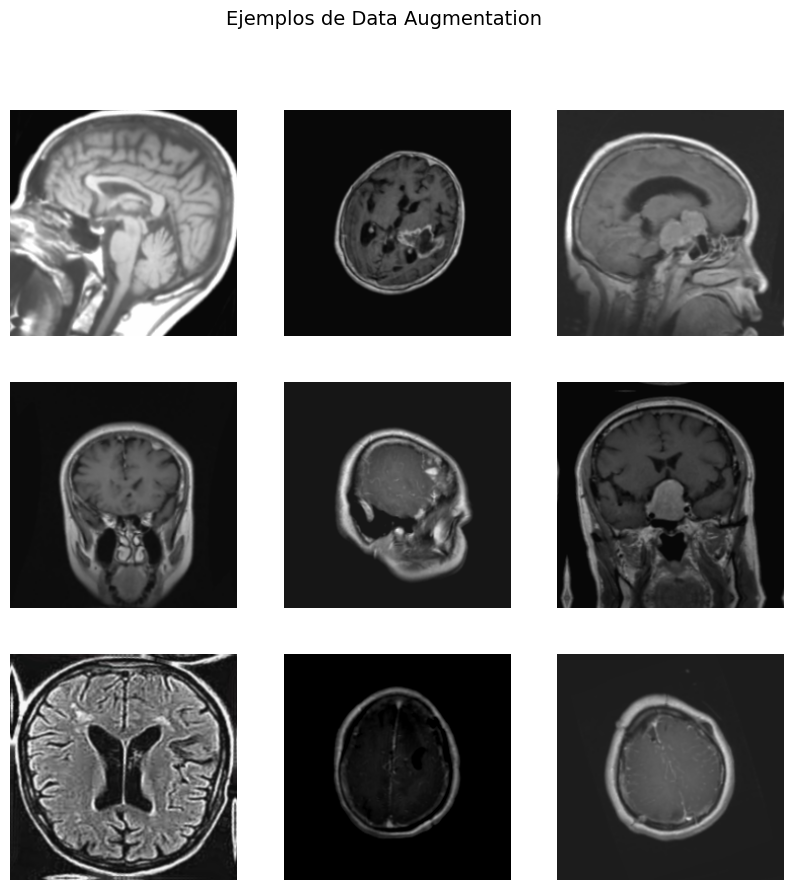

In [7]:
# ==========================================================
# TRAIN DATA AUGMENTATION
# ==========================================================

def data_augmentation(split_dir:str, seed:int, batch_size:int, image_size:tuple):
    # Cargar imágenes (se necesita tamaño fijo)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'{split_dir}/train',
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        image_size=image_size
    )

    class_names = train_ds.class_names
    print("Clases detectadas:", class_names)

    # 🔹 Crear mapeo explícito de índice → nombre
    label_map = {i: name for i, name in enumerate(class_names)}
    print("\nMapeo de etiquetas:")
    for key, value in label_map.items():
        print(f"{key} → {value}")

    # Definir Data Augmentation
    data_augmentation = tf.keras.Sequential([
        RandomRotation(0.05),
        RandomZoom(0.1),
        RandomContrast(0.1),
        RandomBrightness(0.1),
    ])

    # Aplicar aumentación
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    print("\n Data augmentation aplicada al conjunto de entrenamiento.")
    return train_ds, data_augmentation, class_names, label_map


def plot_data_augmentation(train_ds, data_augmentation):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(9):
            augmented = data_augmentation(images, training=True)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented[i].numpy().astype("uint8"))
            plt.axis("off")
        plt.suptitle("Ejemplos de Data Augmentation", fontsize=14)
        plt.show()
        break


# Ejecutar data augmentation
train_ds, data_aug, class_names, label_map = data_augmentation(split_dir, seed, batch_size, image_size)
plot_data_augmentation(train_ds, data_aug)

Mapeo de etiquetas numéricas a nombres de clase:



,Etiqueta numérica,Clase
0,0,glioma
1,1,healthy
2,2,meningioma
3,3,pituitary



Shape de las imágenes: (32, 224, 224, 3)


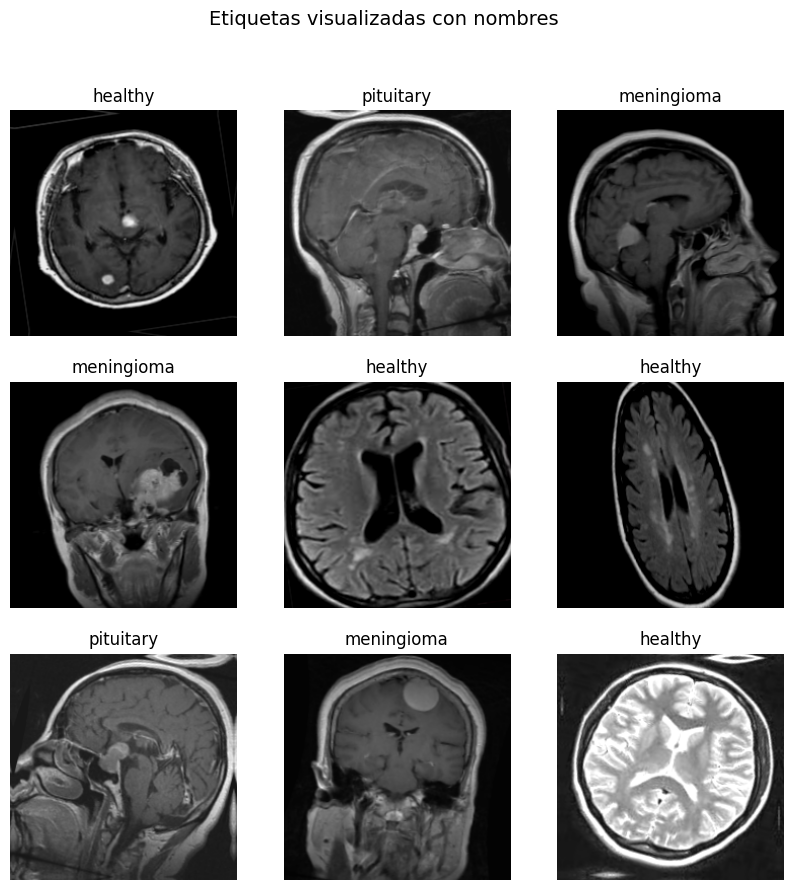

In [8]:
# ==========================================================
# TRAIN LABEL VERIFICATION
# ==========================================================

def get_label(train_ds, class_names, label_map):

    # Mostrar forma y etiquetas del primer batch
    for images, labels in train_ds.take(1):
        print("\nShape de las imágenes:", images.shape)

        # Mostrar 9 imágenes con sus nombres de clase
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_idx = labels[i].numpy()
            plt.title(label_map[label_idx])
            plt.axis("off")
        plt.suptitle("Etiquetas visualizadas con nombres", fontsize=14)
        plt.show()
        break


# Ejecutar
get_label(train_ds, class_names, label_map)


In [9]:
# ==========================================================
# CREA EL MODELO
# ==========================================================
def create_model(hp):

  #Inicializa el modelo
  model = Sequential(name = "mri-model")

  #Capa de entrada (las imágenes son de tamaño variable)
  model.add(Input(shape=(None,None,3)))

  #Primera capa: Capa de resizing
  model.add(Resizing(image_size[0], image_size[1]))

  #Segunda capa: Capa de normalización
  model.add(Rescaling(1./255))

  #Bloque convolucional 1
  model.add(Conv2D(
      filters=hp.Choice('filters_block1', [32, 64, 96]),
      kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))

  #Bloque convolucional 2
  model.add(Conv2D(
      filters=hp.Choice('filters_block2', [64, 96, 128]),
      kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))

  #Bloque convolucional 3
  model.add(Conv2D(
      filters=hp.Choice('filters_block3', [96, 128, 160]),
      kernel_size=(3,3), activation='relu', padding='same'
  ))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))

  #Bloque denso
  model.add(Flatten())
  model.add(Dropout(hp.Choice('dropout_1', [0.3, 0.4, 0.5])))
  model.add(Dense(
      units=hp.Choice('dense_units', [128, 192, 256]),
      activation='relu'))
  model.add(Dropout(hp.Choice('dropout_2', [0.2, 0.3, 0.4])))
  model.add(Dense(4, activation='softmax'))

  # Optimizador y learning rate
  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=lr)

  #Función de pérdida
  loss = SparseCategoricalCrossentropy()

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy',
               AUC(multi_label=True, num_labels=4, name='auc')]
  )

  return model

# ==========================================================
# BUSQUEDA DE HIPERPARÁMETROS
# ==========================================================

tuner = RandomSearch(
    create_model,
    objective='val_auc',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='cnn_mri_tuning'
)

# ==========================================================
# ENTRENAMIENTO
# ==========================================================

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    verbose=1
)

#Mejor modelo
tuner.results_summary()
best_model = tuner.get_best_models(num_models=1)[0]

NameError: name 'RandomSearch' is not defined